## Setting up General

In [1]:
using InteractiveUtils

macro bind(def, element)
    quote
        local el = $(esc(element))
        global $(esc(def)) = Core.applicable(Base.get, el) ? Base.get(el) : missing
        el
    end
end

@bind (macro with 1 method)

In [2]:
using Pkg

Pkg.activate(raw"D:\wljulia")
# Pkg.Registry.update()
# Pkg.add("BenchmarkTools")
# Pkg.add("PlutoUI")
# Pkg.add("Tar")
# Pkg.add("MLDataPattern")
# Pkg.add("Glob")
# Pkg.add("NIfTI")
# Pkg.add("CairoMakie")
# Pkg.add("ImageCore")
# Pkg.add("DataLoaders")
# Pkg.add("CUDA")
# Pkg.add("FastAI")
# Pkg.add("Images")
# Pkg.add("FilePathsBase")
# Pkg.add("FixedPointNumbers")
# Pkg.add("Colors")
# Pkg.add("ProgressBars")
# Pkg.add("LinearAlgebra")
# Pkg.add("StaticArrays")
        

  Activating project at `D:\wljulia`


In [3]:
Pkg.add("DataFrames")
Pkg.add("CSV")
using DataFrames
using CSV

    Updating registry at `C:\Users\Administrator.WIN-2EPKD7D6018\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `D:\wljulia\Project.toml`
  No Changes to `D:\wljulia\Manifest.toml`
   Resolving package versions...
  No Changes to `D:\wljulia\Project.toml`
  No Changes to `D:\wljulia\Manifest.toml`


In [4]:
using PlutoUI
using BenchmarkTools
using Colors: Gray
using FixedPointNumbers: N0f8
using Tar
using MLDataPattern
using Glob
using NIfTI
using CairoMakie
using ImageCore
using DataLoaders
using CUDA
using FastAI
using FastAI: DataAugmentation
using Images
using FilePathsBase
using ProgressBars
using LinearAlgebra
using StaticArrays

In [5]:
TableOfContents()

TableOfContents("Table of Contents", true, 3, true)

## Load Data

## Load data
Part of the [Medical Decathlon Dataset](http://medicaldecathlon.com/)

In [6]:
data_dir = raw"G:\molloi-lab\project-distance-transforms\Task02_Heart"

"G:\\molloi-lab\\project-distance-transforms\\Task02_Heart"

In [7]:
function loadfn_label(p)
    a = NIfTI.niread(string(p)).raw
    convert_a = convert(Array{UInt8}, a)
    convert_a = convert_a .+ 1
    return convert_a
end

function loadfn_image(p)
    a = NIfTI.niread(string(p)).raw
    convert_a = convert(Array{Float32}, a)
    convert_a = convert_a / max(convert_a...)
    return convert_a
end

loadfn_image (generic function with 1 method)

In [8]:
begin
    images(dir) = mapobs(loadfn_image, Glob.glob("*.nii*", dir))
    masks(dir) =  mapobs(loadfn_label, Glob.glob("*.nii*", dir))
    pre_data = (
        images(joinpath(data_dir, "imagesTr")),
        masks(joinpath(data_dir, "labelsTr")),
    )
end

(mapobs(loadfn_image, ["G:\\molloi-lab\\project-distance-transforms\\Task02_Heart\\imagesTr\\la_003.ni…]), mapobs(loadfn_label, ["G:\\molloi-lab\\project-distance-transforms\\Task02_Heart\\labelsTr\\la_003.ni…]))

In [9]:
image, mask = sample = getobs(pre_data, 1);

In [10]:
@info typeof(image)

┌ Info: Array{Float32, 3}
└ @ Main In[10]:1


In [11]:
image_size = (96, 96, 96)

(96, 96, 96)

In [12]:
function presize(files)
    container_images = Array{eltype(image)}(undef, image_size..., nobs(files))
    container_masks = Array{eltype(mask)}(undef, image_size..., nobs(files))
    for i in 1:nobs(files)
        image, mask = getobs(files, i)
        img = imresize(image, image_size)
        msk = round.(imresize(mask, image_size))
        container_images[:, :, :, i] = img
        container_masks[:, :, :, i] = msk
    end
    return container_images, container_masks
end

presize (generic function with 1 method)

In [13]:
img_container, _ = presize(pre_data);

In [14]:
files_cache = presize(pre_data);

In [15]:
function loadfn_pre(a)
    return a
end

loadfn_pre (generic function with 1 method)

In [16]:
begin
    images_pre(arr) = mapobs(loadfn_pre, arr)
    masks_pre(arr) =  mapobs(loadfn_pre, arr)
    data = (
        images_pre(files_cache[1]),
        masks_pre(files_cache[2]),
    )
end

(mapobs(loadfn_pre, [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0…]), mapobs(loadfn_pre, [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1…]))

In [17]:
@info nobs(images(joinpath(data_dir, "imagesTr")))

┌ Info: 20
└ @ Main In[17]:1


In [18]:
a, b = FastAI.Vision.imagedatasetstats(img_container, Gray{N0f8}, progressfn = identity) 
mean, std = SVector{1, Float32}(a), SVector{1, Float32}(b)

(Float32[0.090980366], Float32[0.13637379])

In [19]:
train_files, val_files = MLDataPattern.splitobs(data, 0.8)

((DataSubset(::FastAI.Datasets.MappedData{typeof(loadfn_pre), Array{Float32, 4}}, ::UnitRange{Int64}, ObsDim.Undefined())
 16 observations, DataSubset(::FastAI.Datasets.MappedData{typeof(loadfn_pre), Array{Int64, 4}}, ::UnitRange{Int64}, ObsDim.Undefined())
 16 observations), (DataSubset(::FastAI.Datasets.MappedData{typeof(loadfn_pre), Array{Float32, 4}}, ::UnitRange{Int64}, ObsDim.Undefined())
 4 observations, DataSubset(::FastAI.Datasets.MappedData{typeof(loadfn_pre), Array{Int64, 4}}, ::UnitRange{Int64}, ObsDim.Undefined())
 4 observations))

In [20]:
image, mask = sample = getobs(data, 1);

In [21]:
@bind a PlutoUI.Slider(1:size(image, 3), default=50, show_value=true)

PlutoUI.BuiltinsNotebook.Slider{Int64}(1:96, 50, true)

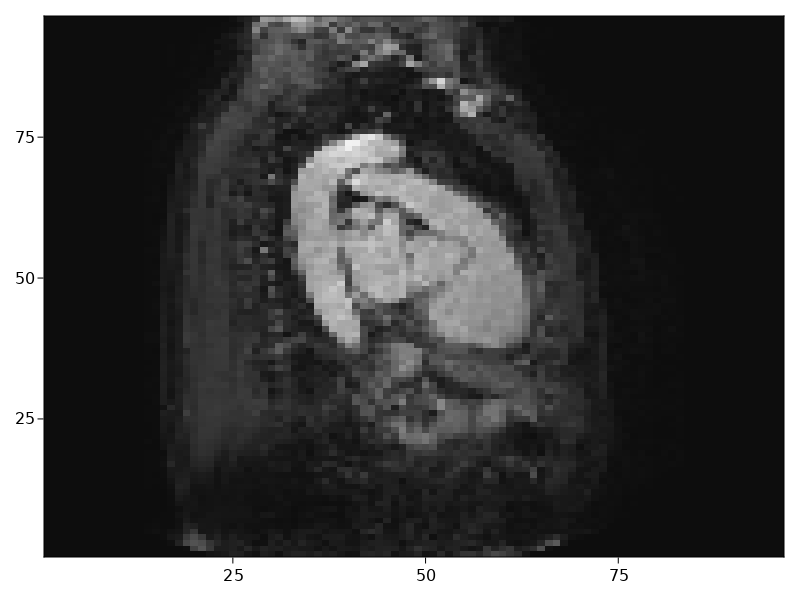

In [22]:
heatmap(image[:, :, a], colormap=:grays)

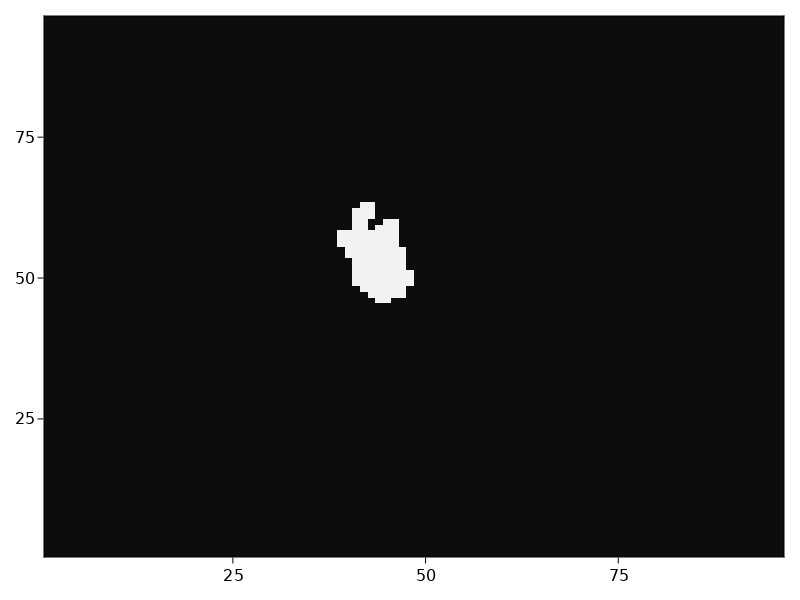

In [23]:
heatmap(mask[:, :, a], colormap=:grays)

## Create Learning Task

In [24]:
task = SupervisedTask(
    (FastAI.Vision.Image{3}(), Mask{3}(1:2)),
    (
        ProjectiveTransforms((image_size)),
        ImagePreprocessing(means = mean, stds = std, C = Gray{N0f8}),
        OneHot()
    )
)

SupervisedTask(FastAI.Vision.Image{3} -> Mask{3, Int64})

In [25]:
describetask(task)

**`SupervisedTask` summary**

Learning task for the supervised task with input `FastAI.Vision.Image{3}` and target `Mask{3, Int64}`. Compatible with `model`s that take in `Bounded{3, FastAI.Vision.ImageTensor{3}}` and output `Bounded{3, FastAI.OneHotTensor{3, Int64}}`.

Encoding a sample (`encodesample(task, context, sample)`) is done through the following encodings:

|               Encoding |              Name |                                 `blocks.input` |                                 `blocks.target` |
| ----------------------:| -----------------:| ----------------------------------------------:| -----------------------------------------------:|
|                        | `(input, target)` |                       `FastAI.Vision.Image{3}` |                                `Mask{3, Int64}` |
| `ProjectiveTransforms` |                   |       **`Bounded{3, FastAI.Vision.Image{3}}`** |                **`Bounded{3, Mask{3, Int64}}`** |
|   `ImagePreprocessing` |                   | **`Bounded{3, FastAI.Vision.ImageTensor{3}}`** |                                                 |
|               `OneHot` |          `(x, y)` |                                                | **`Bounded{3, FastAI.OneHotTensor{3, Int64}}`** |


## Visualize

In [26]:
xs, ys = FastAI.makebatch(task, data, 1:3);

In [27]:
@bind b PlutoUI.Slider(1:size(xs, 3), default=50, show_value=true)

PlutoUI.BuiltinsNotebook.Slider{Int64}(1:96, 50, true)

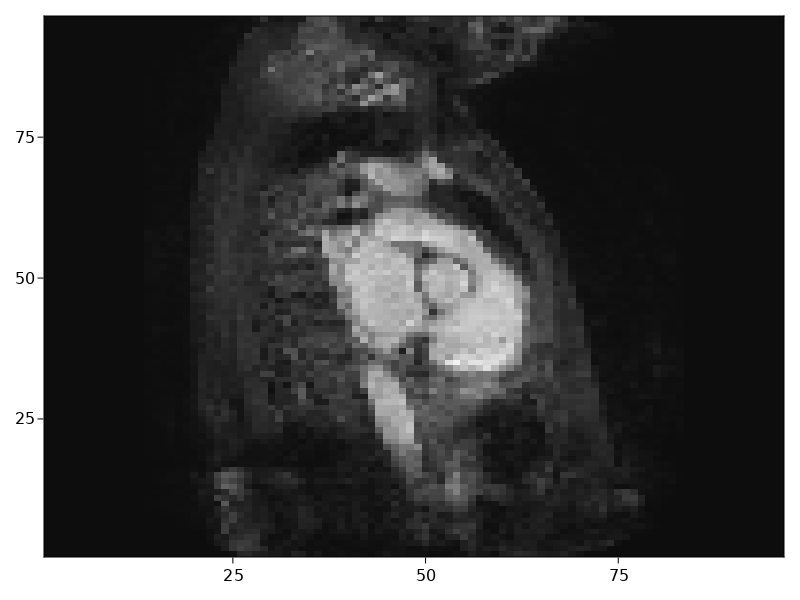

In [28]:
heatmap(xs[:, :, b, 1, 2], colormap=:grays)

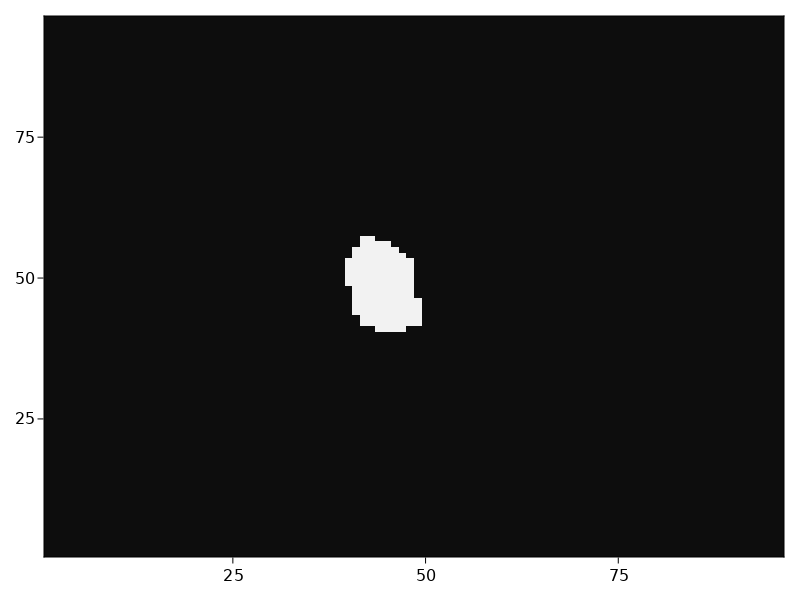

In [29]:
heatmap(ys[:, :, b, 2, 2], colormap=:grays)

## Dataloader

In [30]:
tdl, vdl = taskdataloaders(data, task, 1)

(DataLoaders.GetObsParallel{DataLoaders.BatchViewCollated{FastAI.TaskDataset{Tuple{DataSubset{FastAI.Datasets.MappedData{typeof(loadfn_pre), Array{Float32, 4}}, SubArray{Int64, 1, Vector{Int64}, Tuple{UnitRange{Int64}}, true}, LearnBase.ObsDim.Undefined}, DataSubset{FastAI.Datasets.MappedData{typeof(loadfn_pre), Array{Int64, 4}}, SubArray{Int64, 1, Vector{Int64}, Tuple{UnitRange{Int64}}, true}, LearnBase.ObsDim.Undefined}}, SupervisedTask{NamedTuple{(:input, :target, :sample, :encodedsample, :x, :y, :ŷ, :pred), Tuple{FastAI.Vision.Image{3}, Mask{3, Int64}, Tuple{FastAI.Vision.Image{3}, Mask{3, Int64}}, Tuple{Bounded{3, FastAI.Vision.ImageTensor{3}}, Bounded{3, FastAI.OneHotTensor{3, Int64}}}, Bounded{3, FastAI.Vision.ImageTensor{3}}, Bounded{3, FastAI.OneHotTensor{3, Int64}}, Bounded{3, FastAI.OneHotTensor{3, Int64}}, Bounded{3, Mask{3, Int64}}}}, Tuple{ProjectiveTransforms{3, NamedTuple{(:training, :validation, :inference), Tuple{DataAugmentation.BufferedThreadsafe, DataAugmentation.B

In [40]:
traindl, validdl = tdl |> gpu, vdl |> gpu

(DataLoaders.GetObsParallel{DataLoaders.BatchViewCollated{FastAI.TaskDataset{Tuple{DataSubset{FastAI.Datasets.MappedData{typeof(loadfn_pre), Array{Float32, 4}}, SubArray{Int64, 1, Vector{Int64}, Tuple{UnitRange{Int64}}, true}, LearnBase.ObsDim.Undefined}, DataSubset{FastAI.Datasets.MappedData{typeof(loadfn_pre), Array{Int64, 4}}, SubArray{Int64, 1, Vector{Int64}, Tuple{UnitRange{Int64}}, true}, LearnBase.ObsDim.Undefined}}, SupervisedTask{NamedTuple{(:input, :target, :sample, :encodedsample, :x, :y, :ŷ, :pred), Tuple{FastAI.Vision.Image{3}, Mask{3, Int64}, Tuple{FastAI.Vision.Image{3}, Mask{3, Int64}}, Tuple{Bounded{3, FastAI.Vision.ImageTensor{3}}, Bounded{3, FastAI.OneHotTensor{3, Int64}}}, Bounded{3, FastAI.Vision.ImageTensor{3}}, Bounded{3, FastAI.OneHotTensor{3, Int64}}, Bounded{3, FastAI.OneHotTensor{3, Int64}}, Bounded{3, Mask{3, Int64}}}}, Tuple{ProjectiveTransforms{3, NamedTuple{(:training, :validation, :inference), Tuple{DataAugmentation.BufferedThreadsafe, DataAugmentation.B

## Model

In [32]:
conv = (stride, in, out) -> Conv((3, 3, 3), in=>out, stride=stride, pad=(1, 1, 1))
tran = (stride, in, out) -> ConvTranspose((4, 4, 4), in=>out, stride=stride, pad=1)

conv1 = (in, out) -> Chain(conv(1, in, out), BatchNorm(out), x -> leakyrelu.(x))
conv2 = (in, out) -> Chain(conv(2, in, out), BatchNorm(out), x -> leakyrelu.(x))
tran2 = (in, out) -> Chain(tran(2, in, out), BatchNorm(out), x -> leakyrelu.(x))

#13 (generic function with 1 method)

In [33]:
function unet3D(in_chs, lbl_chs)
    # Contracting layers
    l1 = Chain(conv1(in_chs, 4))
    l2 = Chain(l1, conv1(4, 4), conv2(4, 16))
    l3 = Chain(l2, conv1(16, 16), conv2(16, 32))
    l4 = Chain(l3, conv1(32, 32), conv2(32, 64))
    l5 = Chain(l4, conv1(64, 64), conv2(64, 128))

    # Expanding layers
    l6 = Chain(l5, tran2(128, 64), conv1(64, 64))
    l7 = Chain(Parallel(+, l6, l4), tran2(64, 32), conv1(32, 32))       # Residual connection between l6 & l4
    l8 = Chain(Parallel(+, l7, l3), tran2(32, 16), conv1(16, 16))       # Residual connection between l7 & l3
    l9 = Chain(Parallel(+, l8, l2), tran2(16, 4), conv1(4, 4))          # Residual connection between l8 & l2
    l10 = Chain(l9, conv1(4, lbl_chs))
end

unet3D (generic function with 1 method)

In [34]:
model = unet3D(1, 2) |> gpu;

## Helper Functions

In [35]:
function dice_metric(ŷ, y)
    dice = 2 * sum(ŷ .& y) / (sum(ŷ) + sum(y))
    return dice
end

function as_discrete(array, logit_threshold)
    array = array .>= logit_threshold
    return array
end

as_discrete (generic function with 1 method)

## Loss Functions

In [36]:
function dice_loss(ŷ, y)
    ϵ = 1e-5
    return loss = 1 - ((2 * sum(ŷ .* y) + ϵ) / (sum(ŷ .* ŷ) + sum(y .* y) + ϵ))
end

function hd_loss(ŷ, y, ŷ_dtm, y_dtm)
    M = (ŷ .- y) .^ 2 .* (ŷ_dtm .^ 2 .+ y_dtm .^ 2)
    return loss = mean(M)
end


hd_loss (generic function with 1 method)

## Training

In [54]:
ps = Flux.params(model) 
loss_function = dice_loss 
optimizer = Flux.ADAM(0.01) 

ADAM(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [38]:
max_epochs = 2
val_interval = 2
epoch_loss_values = []
val_epoch_loss_values = []
dice_metric_values = []

Any[]

In [45]:
for (xs, ys) in validdl
    xs, ys = xs |> gpu, ys |> gpu
end

for (xs, ys) in traindl
    xs, ys = xs |> gpu, ys |> gpu
end

In [46]:
function train_step(step,xs,ys)
    xs, ys = xs |> gpu, ys |> gpu
        step += 1
        @show step
        gs = Flux.gradient(ps) do
            ŷs = model(xs)
            loss = loss_function(ŷs[:, :, :, 2, :], ys[:, :, :, 2, :])
            return loss
        end
        Flux.update!(optimizer, ps, gs)
end

function train_epoch(step)
    for (xs, ys) in traindl
        # xs, ys = xs |> gpu, ys |> gpu
        step += 1
        @show step
        gs = Flux.gradient(ps) do
            ŷs = model(xs)
            loss = loss_function(ŷs[:, :, :, 2, :], ys[:, :, :, 2, :])
            return loss
        end
        Flux.update!(optimizer, ps, gs)
    end
end

train_epoch (generic function with 1 method)

In [47]:
step_time_mean = []
step_epoch_mean = []

Any[]

In [55]:
for epoch in 1:max_epochs
    step = 0
    @show epoch

    # epoch_time= @benchmark train_epoch($step)
    # push!(step_epoch_mean, BenchmarkTools.mean(epoch_time).time)

    # Loop through training data
    for (xs, ys) in traindl
        # step_time= @benchmark train_step($step,$xs,$ys)
        # push!(step_time_mean, BenchmarkTools.mean(step_time).time)
        # xs, ys = xs |> gpu, ys |> gpu
        step += 1
        @show step
        gs = Flux.gradient(ps) do
            ŷs = model(xs)
            loss = loss_function(ŷs[:, :, :, 2, :], ys[:, :, :, 2, :])
            return loss
        end
        Flux.update!(optimizer, ps, gs)
    end

    # Loop through validation data
    if (epoch) % val_interval == 0
        val_step = 0
        for (val_xs, val_ys) in validdl
            # val_xs, val_ys = val_xs |> gpu, val_ys |> gpu
            val_step += 1
            @show val_step

            local val_ŷs = model(val_xs)
            local val_loss = loss_function(val_ŷs[:, :, :, 2, :], val_ys[:, :, :, 2, :])
            # val_ŷs, val_ys = as_discrete(val_ŷs, 0.5), as_discrete(val_ys, 0.5)
        end
    end
end

In [ ]:
df = DataFrame(
	step_epoch_mean = step_epoch_mean,
	)

	path = raw"G:\molloi-lab\project-distance-transforms\performance\testing_4_20_epoch_fake.csv"
	CSV.write(path, df)

"G:\\molloi-lab\\project-distance-transforms\\performance\\testing_4_20_epoch_fake.csv"

In [ ]:
CUDA.reclaim()